In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.datasets import make_blobs
from itertools import product
from sklearn.cluster import KMeans
from pandas.plotting import scatter_matrix

import annoy
from annoy import AnnoyIndex
import seaborn as sns
import dateutil
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

%matplotlib inline

In [139]:
pd.set_option('display.max_colwidth', -1)

In [140]:
url = 'city_search.json'

In [141]:
df = pd.read_json(url, orient='columns')

### Getting to know the data

In [142]:
# gather some information about different column in this DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 20021
Data columns (total 5 columns):
cities             20022 non-null object
session_id         20022 non-null object
unix_timestam p    1 non-null object
unix_timestamp     20021 non-null object
user               20022 non-null object
dtypes: object(5)
memory usage: 938.5+ KB


In [143]:
df.head(5)

,cities,session_id,unix_timestam p,unix_timestamp,user
0,"[New York NY, Newark NJ]",[X061RFWB06K9V],NaN,[1442503708],"[[{'user_id': 2024, 'joining_date': '2015-03-22', 'country': 'UK'}]]"
1,"[New York NY, Jersey City NJ, Philadelphia PA]",[5AZ2X2A9BHH5U],NaN,[1441353991],"[[{'user_id': 2853, 'joining_date': '2015-03-28', 'country': 'DE'}]]"
2,[San Antonio TX],[SHTB4IYAX4PX6],NaN,[1440843490],"[[{'user_id': 10958, 'joining_date': '2015-03-06', 'country': 'UK'}]]"
3,[Edmonton AB],[JBRB8MZGTX3M4],NaN,[1427268063],"[[{'user_id': 7693, 'joining_date': '2015-03-12', 'country': 'IT'}]]"
4,"[Phoenix AZ, Houston TX]",[YJCMPURC2FL9C],NaN,[1430559067],"[[{'user_id': 7506, 'joining_date': '2015-02-28', 'country': 'UK'}]]"


In [144]:
# The columns with object dtype are the categorical features in the dataset.
# investigate the raw dataset thoroughly 
# cleaning it?

# analyze the relationship between a categorical 
# feature and a continuous feature by ploting a boxplot. 

In [145]:
# Extracting the individual DataFrame components
# The index, columns and data (values). 
# We can extract each of these components into their own variables.

index = df.index
columns = df.columns
values = df.values

# Selecting a single column of data returns the other pandas data container, the Series.
# A Series is a one-dimensional sequence of labeled data. 
# There are two main components of a Series, the index and the data(or values). 
# There are NO columns in a Series.

# # Selecting rows and columns simultaneously with .loc
# # df.loc[row_selection, column_selection]
# df.loc[1, 'cities']

# # Select all and three columns
# df.loc[0:, ['cities', 'session_id', 'user']]


# You can create a separate DataFrame consisting of only the features by running .copy() 
# any changes made in new DataFrame don't get reflected in the original one.


df.loc[4]
df.loc[1:5]
df.loc[1:3]
index
columns
type(values)
len(df)
df.count()

cities             20022
session_id         20022
unix_timestam p    1    
unix_timestamp     20021
user               20022
dtype: int64

In [146]:
# counts = df['session_id'].value_counts(normalize=True, dropna=False)
colNames = ['cities', 'user']
def extract_country(user):
    return  user[0][0]['country']

flattened_data_frame = pd.DataFrame(columns = ['country', 'cities', 'user'])
flattened_data_frame['cities'] = df['cities'].apply(lambda x: ', '.join(x))

flattened_data_frame['timestamp'] = df['unix_timestamp']
flattened_data_frame['session_id'] = df['session_id']
flattened_data_frame['user'] = df['user'].apply(lambda x:  x[0][0]['user_id'])
flattened_data_frame['country'] = df.apply(lambda x: extract_country(x[colNames[1]]), axis=1)

In [147]:
flattened_data_frame.head(5)

,country,cities,user,timestamp,session_id
0,UK,"New York NY, Newark NJ",2024,[1442503708],[X061RFWB06K9V]
1,DE,"New York NY, Jersey City NJ, Philadelphia PA",2853,[1441353991],[5AZ2X2A9BHH5U]
2,UK,San Antonio TX,10958,[1440843490],[SHTB4IYAX4PX6]
3,IT,Edmonton AB,7693,[1427268063],[JBRB8MZGTX3M4]
4,UK,"Phoenix AZ, Houston TX",7506,[1430559067],[YJCMPURC2FL9C]


In [148]:
number_of_unique_countries = flattened_data_frame['country'].value_counts()
percent_unique_countries = flattened_data_frame['country'].value_counts(normalize=True, dropna=False)

In [149]:

number_of_unique_countries

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

In [150]:
# flattened_data_frame['session_id']..value_counts()

In [151]:
percent_unique_countries

US    0.193587
DE    0.181700
UK    0.177555
      0.140845
FR    0.114774
ES    0.097543
IT    0.093997
Name: country, dtype: float64

In [152]:
# How many countries of origin in total?
len(number_of_unique_countries)

7

In [153]:
number_of_unique_countries

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

In [154]:
number_of_unique_countries

US    3876
DE    3638
UK    3555
      2820
FR    2298
ES    1953
IT    1882
Name: country, dtype: int64

In [155]:
# How many unique users in total?
number_of_unique_users = flattened_data_frame['user'].value_counts()
len(number_of_unique_users)

5777

In [156]:
number_of_unique_users.head(10)

4314    12
4404    12
4082    11
7363    10
9252    10
6508    10
2300    10
7968    9 
4974    9 
3808    9 
Name: user, dtype: int64

In [157]:
# How many sessions in total?
len(flattened_data_frame)

20022

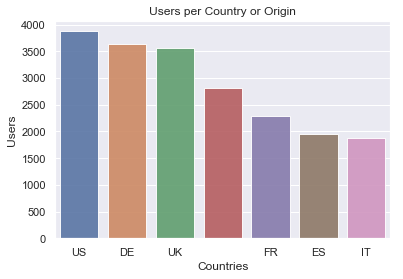

In [158]:
# Plot muber of users per country of origin
categorical_info = flattened_data_frame['country'].value_counts()
sns.set(style="darkgrid")

sns.barplot(categorical_info.index, categorical_info.values, alpha=0.9)
plt.title('Users per Country or Origin')
plt.ylabel('Users', fontsize=12)
plt.xlabel('Countries', fontsize=12)
plt.show()

In [159]:
# Detect missing values
categorical_info.isnull().sum()

0

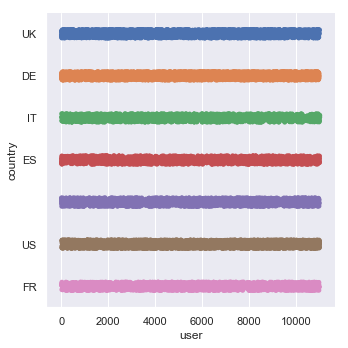

In [160]:
sns.catplot(x="user", y="country", data=flattened_data_frame);

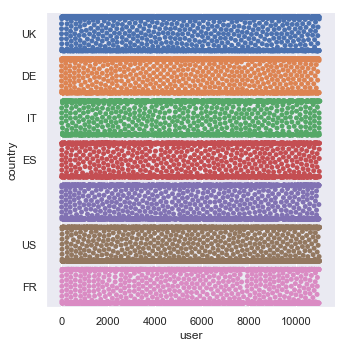

In [161]:
sns.catplot(x="user", y="country", kind="swarm", data=flattened_data_frame);

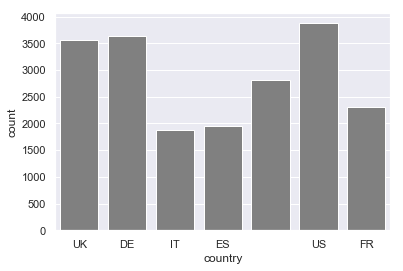

In [162]:
# sns.catplot(x="Cities", y="Country", hue="User", kind="swarm", data=df2);
sns.countplot(flattened_data_frame['country'], color='gray')

In [163]:
users_data = pd.DataFrame(df, columns=['user'])
# colNames = []
# def mapUsers(user):
#     for key, value in user[0][0].items():
#          if key not in colNames:
#             colNames.append(key)
#     return user[0][0]


# users = df.apply(lambda x: mapUsers(x['user']), axis=1)
users_data = df['user'].apply(lambda x: x[0][0])

# Create new pandas dataframe from Series of users dict:
users = pd.DataFrame(list(users_data))
users.tail(10)

,_row,country,joining_date,user_id
20012,536.2,US,2015-03-30,8720
20013,1634.3,IT,2015-03-15,1689
20014,5684.5,,2015-03-31,5726
20015,2869.2,ES,2015-03-22,7761
20016,4533.4,DE,2015-03-30,9513
20017,4235.4,,2015-03-21,4360
20018,3341.3,IT,2015-03-22,2057
20019,2001.6,IT,2015-02-28,1203
20020,2473.5,ES,2015-03-24,3699
20021,4185.3,DE,2015-03-29,2375


In [164]:
# How many users per joining date for US
users['joining_date'][users['country']== 'US']

8        2015-03-22
10       2015-03-21
16       2015-03-21
28       2015-03-21
29       2015-03-30
30       2015-03-07
40       2015-03-28
46       2015-03-10
55       2015-03-16
61       2015-03-03
67       2015-03-22
75       2015-03-01
85       2015-03-04
89       2015-03-31
90       2015-03-17
95       2015-03-13
99       2015-03-09
102      2015-03-23
104      2015-03-09
105      2015-03-28
106      2015-03-27
108      2015-03-09
111      2015-03-17
126      2015-03-28
130      2015-03-13
137      2015-03-04
140      2015-03-09
148      2015-03-23
150      2015-03-05
155      2015-03-25
            ...    
19864    2015-03-28
19875    2015-03-15
19878    2015-03-08
19882    2015-03-04
19884    2015-03-13
19887    2015-03-17
19889    2015-03-24
19894    2015-02-28
19908    2015-03-17
19913    2015-03-17
19936    2015-03-30
19937    2015-03-07
19943    2015-03-23
19950    2015-03-07
19953    2015-03-11
19954    2015-03-28
19957    2015-03-24
19964    2015-03-23
19966    2015-02-28


In [165]:
users['user_id'].nunique()

5777

In [166]:
len(users['user_id'])

20022

In [167]:
type(users['_row'][0])

float

In [168]:
users.groupby('joining_date').count()

,_row,country,user_id
joining_date,,,
2015-02-28,467,677,677
2015-03-01,545,748,748
2015-03-02,612,857,857
2015-03-03,511,705,705
2015-03-04,322,449,449
2015-03-05,249,341,341
2015-03-06,252,344,344
2015-03-07,553,773,773
2015-03-08,454,656,656


In [169]:
# count users per joining date:
users.groupby('joining_date')['joining_date'].count()

joining_date
2015-02-28    677
2015-03-01    748
2015-03-02    857
2015-03-03    705
2015-03-04    449
2015-03-05    341
2015-03-06    344
2015-03-07    773
2015-03-08    656
2015-03-09    638
2015-03-10    673
2015-03-11    473
2015-03-12    279
2015-03-13    360
2015-03-14    764
2015-03-15    829
2015-03-16    743
2015-03-17    759
2015-03-18    460
2015-03-19    315
2015-03-20    359
2015-03-21    804
2015-03-22    633
2015-03-23    742
2015-03-24    690
2015-03-25    452
2015-03-26    261
2015-03-27    377
2015-03-28    646
2015-03-29    714
2015-03-30    720
2015-03-31    704
2015-04-01    415
2015-04-02    304
2015-04-03    358
Name: joining_date, dtype: int64

In [33]:
# count all users:
users.groupby('joining_date')['joining_date'].count().sum()

20022

In [170]:
# How many users join from US for each date?
users.groupby('joining_date')['joining_date'].count()

joining_date
2015-02-28    677
2015-03-01    748
2015-03-02    857
2015-03-03    705
2015-03-04    449
2015-03-05    341
2015-03-06    344
2015-03-07    773
2015-03-08    656
2015-03-09    638
2015-03-10    673
2015-03-11    473
2015-03-12    279
2015-03-13    360
2015-03-14    764
2015-03-15    829
2015-03-16    743
2015-03-17    759
2015-03-18    460
2015-03-19    315
2015-03-20    359
2015-03-21    804
2015-03-22    633
2015-03-23    742
2015-03-24    690
2015-03-25    452
2015-03-26    261
2015-03-27    377
2015-03-28    646
2015-03-29    714
2015-03-30    720
2015-03-31    704
2015-04-01    415
2015-04-02    304
2015-04-03    358
Name: joining_date, dtype: int64

In [35]:
# # What is the sum of users that joined, for each country
# users.groupby('country')['country'].count()
users[users['country'] == ''].groupby('joining_date')['joining_date'].count()

joining_date
2015-02-28    129
2015-03-01    113
2015-03-02    114
2015-03-03    98 
2015-03-04    58 
2015-03-05    44 
2015-03-06    40 
2015-03-07    110
2015-03-08    95 
2015-03-09    96 
2015-03-10    102
2015-03-11    82 
2015-03-12    37 
2015-03-13    44 
2015-03-14    138
2015-03-15    133
2015-03-16    90 
2015-03-17    100
2015-03-18    34 
2015-03-19    29 
2015-03-20    62 
2015-03-21    110
2015-03-22    76 
2015-03-23    74 
2015-03-24    95 
2015-03-25    70 
2015-03-26    11 
2015-03-27    59 
2015-03-28    82 
2015-03-29    114
2015-03-30    126
2015-03-31    106
2015-04-01    46 
2015-04-02    33 
2015-04-03    70 
Name: joining_date, dtype: int64

In [36]:
# What's up with _row field? How many are there?
users['_row'].count()

14245

In [37]:
# What's up with _row field? How many unique
users['_row'].nunique()

14245

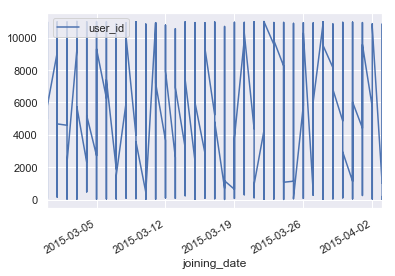

In [38]:
# plot the joining dates:

users.joining_date = pd.to_datetime(users['joining_date'], format='%Y-%m-%d')
users.set_index(['joining_date'], inplace=True)
users.plot()

In [39]:
# Split Pandas Dataframe 'Cities' column containing lists into multiple rows, duplicating the other column's values.

#Following function is taken from: https://gist.github.com/jlln/338b4b0b55bd6984f883 [[[
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s.lstrip()
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df
# ]]]

cities = splitDataFrameList(flattened_data_frame, 'cities', ',')
# rename the column
cities.rename(columns={'cities':'city'}, inplace=True)
cities.head(10)

,city,country,session_id,timestamp,user
0,New York NY,UK,[X061RFWB06K9V],[1442503708],2024
1,Newark NJ,UK,[X061RFWB06K9V],[1442503708],2024
2,New York NY,DE,[5AZ2X2A9BHH5U],[1441353991],2853
3,Jersey City NJ,DE,[5AZ2X2A9BHH5U],[1441353991],2853
4,Philadelphia PA,DE,[5AZ2X2A9BHH5U],[1441353991],2853
5,San Antonio TX,UK,[SHTB4IYAX4PX6],[1440843490],10958
6,Edmonton AB,IT,[JBRB8MZGTX3M4],[1427268063],7693
7,Phoenix AZ,UK,[YJCMPURC2FL9C],[1430559067],7506
8,Houston TX,UK,[YJCMPURC2FL9C],[1430559067],7506
9,San Diego CA,ES,[LKOKP80QD6BEO],[1434199991],3743


In [40]:
cities['city'].value_counts()

New York NY                    5361
Toronto ON                     3279
Los Angeles CA                 2672
Montreal QC                    2336
Chicago IL                     1979
Houston TX                     1394
Vancouver BC                   1376
Philadelphia PA                1056
San Antonio TX                 749 
Phoenix AZ                     723 
San Diego CA                   705 
OTTAWA ON                      694 
Dallas TX                      657 
Jersey City NJ                 611 
Calgary AB                     583 
Newark NJ                      529 
Edmonton AB                    493 
Indianapolis IN                469 
Detroit MI                     427 
San Jose CA                    415 
Jacksonville FL                406 
Columbus OH                    366 
Oshawa ON                      365 
Saint Catharines-Niagara ON    306 
Long Beach CA                  298 
Santa Ana CA                   282 
Anaheim CA                     266 
Austin TX                   

In [41]:
# How many unique cities have been searched by all users?
cities['city'].nunique()

89

In [42]:
# How many unique users
users['user_id'].nunique()

5777

In [43]:
# How many unique countries of origin
users['country'].nunique()

7

In [44]:
dataset_with_country_values = flattened_data_frame[flattened_data_frame['country'] != '']
dataset_with_country_values.head(10)

,country,cities,user,timestamp,session_id
0,UK,"New York NY, Newark NJ",2024,[1442503708],[X061RFWB06K9V]
1,DE,"New York NY, Jersey City NJ, Philadelphia PA",2853,[1441353991],[5AZ2X2A9BHH5U]
2,UK,San Antonio TX,10958,[1440843490],[SHTB4IYAX4PX6]
3,IT,Edmonton AB,7693,[1427268063],[JBRB8MZGTX3M4]
4,UK,"Phoenix AZ, Houston TX",7506,[1430559067],[YJCMPURC2FL9C]
5,ES,San Diego CA,3743,[1434199991],[LKOKP80QD6BEO]
8,US,"Chicago IL, New York NY",365,NaN,[9P74JL5KMC9G9]
10,US,Los Angeles CA,7034,[1442958449],[FASF5QS8ARSGQ]
11,UK,Phoenix AZ,5723,[1434462396],[R9I7W4UA0Y8AM]
12,DE,New York NY,8531,[1429525336],[7NBQMFVHU0GAP]


In [45]:
# How many records with country values
len(dataset_with_country_values)

17202

In [46]:
# How many records with missing country values
dataset_with_no_country_values = flattened_data_frame[flattened_data_frame['country'] == '']
len(dataset_with_no_country_values)

2820

In [47]:
dataset_with_no_country_values.head()

,country,cities,user,timestamp,session_id
6,,"Montreal QC, Chicago IL",8831,[1443171887],[YOVUIM79SGS5Y]
7,,"Calgary AB, New York NY",587,[1431766104],[SHXEY67QWKP9K]
9,,New York NY,5995,[1439104667],[UY49RTVRX3GL7]
19,,"Toronto ON, New York NY",957,[1439713760],[YQAEPPG214CNU]
37,,New York NY,5433,[1436444694],[51H4C2DEYXG5D]


In [48]:
#  convert a column to a category, 
# then use those category values for your label encoding:

# cities['country'] = cities['country'].astype('category')
cities['city'] = cities['city'].astype('category')
# cities["country"] = cities["country"].cat.codes
cities["city"] = cities["city"].cat.codes
# cities.head()

unique_cities = cities.groupby("city").first()
unique_countries = cities.groupby("country").first()

In [49]:
unique_countries

,city,session_id,timestamp,user
country,,,,
,47,[YOVUIM79SGS5Y],[1443171887],8831
DE,50,[5AZ2X2A9BHH5U],[1441353991],2853
ES,71,[LKOKP80QD6BEO],[1434199991],3743
FR,30,[UU2XAOQMP5V35],[1430372377],3607
IT,20,[JBRB8MZGTX3M4],[1427268063],7693
UK,50,[X061RFWB06K9V],[1442503708],2024
US,13,[9P74JL5KMC9G9],[1442958449],365


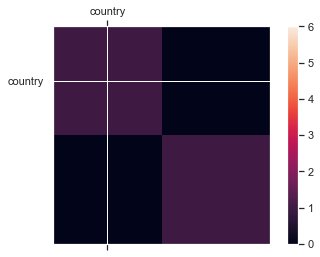

In [50]:
correlations = cities.corr()
names = ['country', 'cities']

# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=0, vmax=6)
fig.colorbar(cax)
ticks = np.arange(0,1,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

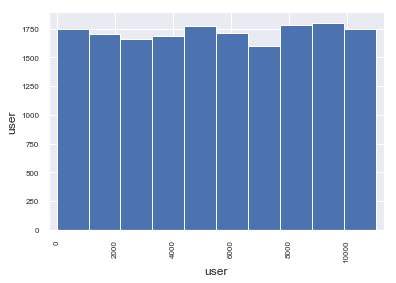

In [51]:
scatter_matrix(dataset_with_country_values)
plt.show()

In [52]:
# !pip install networkx
flattened_data_frame.head(5)

,country,cities,user,timestamp,session_id
0,UK,"New York NY, Newark NJ",2024,[1442503708],[X061RFWB06K9V]
1,DE,"New York NY, Jersey City NJ, Philadelphia PA",2853,[1441353991],[5AZ2X2A9BHH5U]
2,UK,San Antonio TX,10958,[1440843490],[SHTB4IYAX4PX6]
3,IT,Edmonton AB,7693,[1427268063],[JBRB8MZGTX3M4]
4,UK,"Phoenix AZ, Houston TX",7506,[1430559067],[YJCMPURC2FL9C]


In [53]:
def draw_communities(G, countries , pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    countries : list
        A list where the position is the user and the value at the position is the user's country.
        E.g. `print(country[8]) --> 1` means that user's #8 country of origin is country 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """ 
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Convert countries list to a dict where key=country, value=list of users in country
    country_dict = defaultdict(list)
    i = 0
    for user, country in enumerate(countries):
        country_dict[country].append(user)
    
    print(country_dict)
    # Normalize number of countries for choosing a color
#     norm = colors.Normalize(vmin=0, vmax=len(country_dict.keys()))
    
    for country, users in country_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=users,
                               node_color=cm.jet(country),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title("Countries")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

In [54]:
cities.head(14)

,city,country,session_id,timestamp,user
0,50,UK,[X061RFWB06K9V],[1442503708],2024
1,51,UK,[X061RFWB06K9V],[1442503708],2024
2,50,DE,[5AZ2X2A9BHH5U],[1441353991],2853
3,32,DE,[5AZ2X2A9BHH5U],[1441353991],2853
4,58,DE,[5AZ2X2A9BHH5U],[1441353991],2853
5,70,UK,[SHTB4IYAX4PX6],[1440843490],10958
6,20,IT,[JBRB8MZGTX3M4],[1427268063],7693
7,59,UK,[YJCMPURC2FL9C],[1430559067],7506
8,29,UK,[YJCMPURC2FL9C],[1430559067],7506
9,71,ES,[LKOKP80QD6BEO],[1434199991],3743


In [55]:

# def map_user_country(user):
#     return  user[0][0]['country']
# countries = []
# countries = cities.apply(lambda x: map_user_country(x[colNames[1]]), axis=1)
user_country_map = cities.loc[:, 'country']

In [56]:
user_country_map.head(10)


0    UK
1    UK
2    DE
3    DE
4    DE
5    UK
6    IT
7    UK
8    UK
9    ES
Name: country, dtype: object

In [57]:
type(user_country_map)

pandas.core.series.Series

In [58]:
user_country_map = user_country_map.tolist()

In [59]:
user_country_map[:13]

['UK', 'UK', 'DE', 'DE', 'DE', 'UK', 'IT', 'UK', 'UK', 'ES', '', '', '']

In [60]:
from matplotlib import colors as colors

In [61]:
# G=nx.from_pandas_edgelist(cities, source='country', target='user')
# pos = nx.spring_layout(G, iterations=10)

In [62]:
# draw_communities(G, user_country_map, pos)

In [63]:
cities.head(10)

,city,country,session_id,timestamp,user
0,50,UK,[X061RFWB06K9V],[1442503708],2024
1,51,UK,[X061RFWB06K9V],[1442503708],2024
2,50,DE,[5AZ2X2A9BHH5U],[1441353991],2853
3,32,DE,[5AZ2X2A9BHH5U],[1441353991],2853
4,58,DE,[5AZ2X2A9BHH5U],[1441353991],2853
5,70,UK,[SHTB4IYAX4PX6],[1440843490],10958
6,20,IT,[JBRB8MZGTX3M4],[1427268063],7693
7,59,UK,[YJCMPURC2FL9C],[1430559067],7506
8,29,UK,[YJCMPURC2FL9C],[1430559067],7506
9,71,ES,[LKOKP80QD6BEO],[1434199991],3743


In [64]:
# cities['country'] = cities['country'].astype('category')
# cities["country"] = cities["country"].cat.codes

In [65]:
from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=7)
# neigh.fit(cities.iloc[:,0:4], cities['country'])

In [66]:
cities.head(3)

,city,country,session_id,timestamp,user
0,50,UK,[X061RFWB06K9V],[1442503708],2024
1,51,UK,[X061RFWB06K9V],[1442503708],2024
2,50,DE,[5AZ2X2A9BHH5U],[1441353991],2853


In [67]:

# X = cities.loc[:, ['city','user']]
# Y = cities.loc[:, 'country']

X = np.matrix(cities.loc[:, ['city','user']])
y = np.array(cities.loc[:, 'country'])

# h = .02 # step size in the mesh

# knn=KNeighborsClassifier()

# # we create an instance of Neighbours Classifier and fit the data.
# knn.fit(X, Y)

# # Plot the decision boundary. For that, we will asign a color to each
# # point in the mesh [x_min, m_max]x[y_min, y_max].
# x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
# y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# pl.figure(1, figsize=(4, 3))
# pl.set_cmap(pl.cm.Paired)
# pl.pcolormesh(xx, yy, Z)

# # Plot also the training points
# pl.scatter(X[:,0], X[:,1],c=Y )
# pl.xlabel('User')
# pl.ylabel('Cities')

# pl.xlim(xx.min(), xx.max())
# pl.ylim(yy.min(), yy.max())
# pl.xticks(())
# pl.yticks(())

# pl.show()

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
cities_to_train = cities[cities['country'] != '']
predict_data = cities[cities['country'] == '']

In [70]:
X_train = np.matrix(cities_to_train.loc[:, ['city','user']])
y_train = np.array(cities_to_train.loc[:, 'country'])

In [71]:
X_train[:10]

matrix([[   50,  2024],
        [   51,  2024],
        [   50,  2853],
        [   32,  2853],
        [   58,  2853],
        [   70, 10958],
        [   20,  7693],
        [   59,  7506],
        [   29,  7506],
        [   71,  3743]])

In [72]:
# !pip install mlxtend

In [73]:
from sklearn import svm
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [74]:
# Fit Support Vector Machine Classifier
cities_to_train_sample = cities_to_train
X = cities_to_train_sample[['city', 'user']]
y = cities_to_train_sample['country']

np.save('X', X)
np.save('y', y)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X, y) 

# # Plot Decision Region using mlxtend's plotting function
# plot_decision_regions(X=X.values, 
#                       y=y.values,
#                       clf=clf, 
#                       legend=2)

# # Update plot object with X/Y axis labels and Figure Title
# plt.xlabel(X.columns[1], size=14)
# plt.ylabel(X.columns[0], size=14)
# plt.title('SVM Decision Region Boundary', size=16)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
X_predict = np.matrix(predict_data.loc[:, ['city','user']]) 
np.save('X_predict', X_predict)
X_predict = StandardScaler().fit_transform(X_predict.astype(float))
Y_predict = clf.predict(X_predict)

In [76]:
clf.classes_

array(['DE', 'ES', 'FR', 'IT', 'UK', 'US'], dtype=object)

In [77]:
clf.score(X, y)

0.23248934746628164

In [78]:
unique, counts = np.unique(Y_predict, return_counts=True)
print (np.asarray((unique, counts)).T)

[['DE' 1061]
 ['UK' 782]
 ['US' 2776]]


### Create train/test multi-label sets, fit, and predict

In [79]:
from sklearn.multiclass import OneVsRestClassifier

cities_to_train_sample = cities_to_train
X = cities_to_train_sample[['city', 'user']]
y = cities_to_train_sample['country']
random_state = np.random.RandomState(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

clf = OneVsRestClassifier(svm.SVC(decision_function_shape='ovr')).fit(X_train, y_train)

In [80]:
clf.classes_

array(['DE', 'ES', 'FR', 'IT', 'UK', 'US'],
      dtype='<U2')

In [81]:
y_score = clf.decision_function(X_test)

In [82]:
y_test_predicted = clf.predict(X_test)

In [83]:
y_test_predicted[:10]

array(['DE', 'US', 'DE', 'IT', 'US', 'US', 'US', 'US', 'ES', 'FR'],
      dtype='<U2')

In [84]:
# y_test_array = list(zip(y_test,y_test.index))

In [85]:
 print ("Accuracy: %s" % clf.score(X_test, y_test))

Accuracy: 0.450528169014


In [86]:
type(y_test)

pandas.core.series.Series

In [87]:
y_test.head(2)

19989    DE
11374    FR
Name: country, dtype: object

In [88]:
# y_true = y_test.as_matrix()
y_true = y_test.values

In [89]:
y_true.shape

(5680,)

In [90]:
y_score.shape

(5680, 6)

In [91]:
y_test_predicted[:20]

array(['DE', 'US', 'DE', 'IT', 'US', 'US', 'US', 'US', 'ES', 'FR', 'US',
       'US', 'IT', 'US', 'US', 'US', 'DE', 'US', 'US', 'DE'],
      dtype='<U2')

In [92]:
y_true[: 20]

array(['DE', 'FR', 'DE', 'IT', 'IT', 'US', 'US', 'ES', 'ES', 'FR', 'UK',
       'DE', 'IT', 'FR', 'FR', 'IT', 'DE', 'US', 'IT', 'DE'], dtype=object)

In [93]:
accuracy = (y_test_predicted == y_true).mean()

In [94]:
accuracy

0.45052816901408449

### Present results

### The average precision score in multi-label settings


In [95]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def precision(y_true, y_pred):
    i = np.sum(y_true == y_pred)
    len1 = len(y_pred)
    print('i:', i, ' len1: ', len1)
    if len1 == 0:
        return 0
    else:
        return i / len1


def recall(y_true, y_pred):
    i = np.sum(y_true == y_pred)
    return i / len(y_true)


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

print('Precision on test set:', precision(y_true, y_score))
print('Recal on test set:', recall(y_true, y_score))
print('F1 score on test set:', f1_score(y_true, y_score))

    
# # For each class
# precision = dict()
# recall = dict()
# average_precision = dict()
# for i in range(len(clf.classes_)):
#     precision[i], recall[i], _ = precision_recall_curve(y_true[i],y_score[i])
#     average_precision[i] = average_precision_score(y_true[i], y_score[i])

# # A "micro-average": quantifying score on all classes jointly
# precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),
#     y_score.ravel())
# average_precision["micro"] = average_precision_score(y_true, y_score,
#                                                      average="micro")
# print('Average precision score, micro-averaged over all classes: {0:0.2f}'
#       .format(average_precision["micro"]))

i: 0  len1:  5680
Precision on test set: 0.0
Recal on test set: 0.0
i: 0  len1:  5680
F1 score on test set: 0


/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """
/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app


In [96]:
predict_data.head(5)

,city,country,session_id,timestamp,user
10,47,,[YOVUIM79SGS5Y],[1443171887],8831
11,13,,[YOVUIM79SGS5Y],[1443171887],8831
12,9,,[SHXEY67QWKP9K],[1431766104],587
13,50,,[SHXEY67QWKP9K],[1431766104],587
16,50,,[UY49RTVRX3GL7],[1439104667],5995


In [97]:
# X_train

In [98]:
X_predict = np.matrix(predict_data.loc[:, ['city','user']]) 


In [99]:
X_predict.shape

(4619, 2)

In [100]:
Y_predict = clf.predict(X_predict)

In [101]:
Y_predict

array(['US', 'US', 'ES', ..., 'US', 'IT', 'US'],
      dtype='<U2')

In [102]:
Y_predict.shape

(4619,)

In [103]:
print(clf.decision_function(X_predict))

[[-0.75330407 -0.87939814 -0.85932608 -0.72970072 -0.75504457 -0.72090365]
 [-0.71258827 -0.85949568 -0.83428573 -0.86683278 -0.71469056 -0.68522897]
 [-0.75146561 -0.72416039 -0.85667291 -0.88482557 -0.75331257 -0.72776689]
 ..., 
 [-0.71258228 -0.85949652 -0.83428672 -0.86683358 -0.71469228 -0.68523083]
 [-0.88685309 -0.94486601 -0.93452387 -0.26030211 -0.88764823 -0.87619579]
 [-0.71770345 -0.86200019 -0.83725725 -0.86158799 -0.70551461 -0.69083112]]


In [104]:
np.unique(Y_predict)

array(['DE', 'ES', 'FR', 'IT', 'UK', 'US'],
      dtype='<U2')

In [105]:
unique, counts = np.unique(Y_predict, return_counts=True)

print (np.asarray((unique, counts)).T)

[['DE' '445']
 ['ES' '154']
 ['FR' '236']
 ['IT' '123']
 ['UK' '382']
 ['US' '3279']]


In [106]:
Y_predict[1]

'US'

In [107]:
X.shape

(28397, 2)

In [108]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)


In [109]:
clf_kn = KNeighborsClassifier(7)
clf_kn.fit(X_train, y_train)
score = clf_kn.score(X_test, y_test)

In [110]:
score

0.2272887323943662

In [111]:
X_predict = StandardScaler().fit_transform(X_predict.astype(float))

In [112]:
Y_pred = clf.predict(X_predict)

In [113]:
unique, counts = np.unique(Y_pred, return_counts=True)

print (np.asarray((unique, counts)).T)

[['US' '4619']]


In [114]:
len(Y_pred)

4619

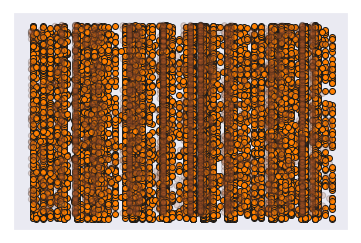

In [115]:
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(111)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
y_train_colors = plt.cm.Paired(7)  
y_test_colors = plt.cm.Paired(range(len(Y_pred)))
# Plot also the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_colors, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(X_predict[:, 0], X_predict[:, 1], c=y_test_colors, cmap=cm_bright,
           edgecolors='k', alpha=0.2)

ax.set_xticks(())
ax.set_yticks(())
plt.show()

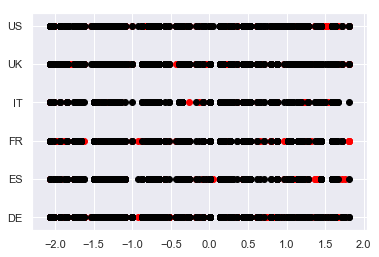

In [116]:
y_test_predicted = clf_kn.predict(X_test)
plt.scatter(X_test[:, 0], y_test_predicted,  color='red', label='A')
plt.scatter(X_test[:, 0], y_test,  color='black', label='B')

### Number of Unique Users per Session

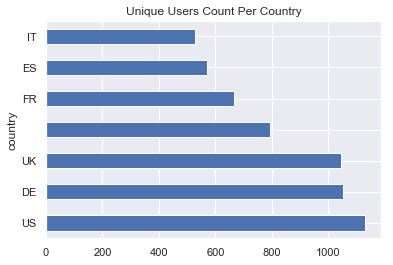

In [117]:
_ = flattened_data_frame.groupby("country")["user"] \
    .nunique() \
    .sort_values(ascending=False) \
    .plot(kind="barh", figsize=(6,4), title="Unique Users Count Per Country")

In [118]:
flattened_data_frame.groupby("country")["user"].nunique().sum()

5777

In [119]:
flattened_data_frame.head(3)

,country,cities,user,timestamp,session_id
0,UK,"New York NY, Newark NJ",2024,[1442503708],[X061RFWB06K9V]
1,DE,"New York NY, Jersey City NJ, Philadelphia PA",2853,[1441353991],[5AZ2X2A9BHH5U]
2,UK,San Antonio TX,10958,[1440843490],[SHTB4IYAX4PX6]


###  Try classifier without breaking down city list

In [120]:

flattened_data_frame['cities'] = flattened_data_frame['cities'].astype('category')
flattened_data_frame["cities"] = flattened_data_frame["cities"].cat.codes


train_data = flattened_data_frame[flattened_data_frame['country'] != '']
predict_data_full = flattened_data_frame[flattened_data_frame['country'] == '']

X = train_data[['cities', 'user']]
y = train_data['country']

np.save('X', X)
np.save('y', y)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

clf = svm.SVC(decision_function_shape='ovr')
clf.fit(X_train, y_train)

clf.score(X_test, y_test)


0.23074687590816623

In [121]:
X

array([[ 0.26617044, -1.09882347],
       [ 0.21113776, -0.83930819],
       [ 0.86877828,  1.69793112],
       ..., 
       [-1.75903216, -1.35583439],
       [-1.84708445, -0.57447112],
       [ 1.20998089, -0.98894426]])

In [122]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [123]:
X_predict = np.matrix(predict_data_full.loc[:, ['cities','user']]) 
np.save('X_predict', X_predict)
X_predict = StandardScaler().fit_transform(X_predict.astype(float))
Y_predict = clf.predict(X_predict)

unique, counts = np.unique(Y_predict, return_counts=True)
print (np.asarray((unique, counts)).T)

[['DE' 545]
 ['UK' 412]
 ['US' 1863]]


In [124]:
a =flattened_data_frame[flattened_data_frame['country'] == '']
b =flattened_data_frame[flattened_data_frame['country'] != '']

In [125]:
print(len(flattened_data_frame), len(a), len(b))

20022 2820 17202


In [126]:
X_test.shape

(3441, 2)

In [127]:
y_test.shape

(3441,)

In [128]:
predictions = clf.predict(X_test)

# fig, ax = plt.subplots()

# ax.scatter(X_test, y_test)
# ax.scatter(X_test, predictions, edgecolors=(0, 0, 0))
# ax.set_xticks(())
# ax.set_yticks(())
    
# # ax.set_xlabel('Measured')
# # ax.set_ylabel('Predicted')
# plt.show()


# plt.plot(X_test, clf.predict(X_test), color='red', linewidth=1)
# plt.scatter(X_test[:, 0], predictions,  color='red', label='A')
# plt.scatter(X_test[:, 0], y_test,  color='black', label='B')